# In-Processing Mitigation

##  Logistic Regression

In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

In [323]:
df = pd.read_csv('peranna2.csv')

In [324]:
# Features we want to use
features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'fam_inc', 'tier', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white']

# Target variable
target = 'pass_bar'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

### Fairness Constrain on fam_inc 

We will first try with **Fairness Constrained** on Logistic Regression, intervening directly on the loss function introducing 
Demographic Parity, Equal Opportunity, Equalized Odds.

In [7]:
mitigator = ExponentiatedGradient(
    # Let's use the same parameters as the best model we previously trained
    LogisticRegression(max_iter=1000, C=1, class_weight={0: 10, 1: 1}),
    constraints=DemographicParity()
)

# Fit model with fairness constraint on fam_income
mitigator.fit(X_train, y_train, sensitive_features=X_train['fam_inc'])

# Predict on test set
y_pred = mitigator.predict(X_test)

In [8]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 214   13]
 [3412  776]]
              precision    recall  f1-score   support

           0       0.06      0.94      0.11       227
           1       0.98      0.19      0.31      4188

    accuracy                           0.22      4415
   macro avg       0.52      0.56      0.21      4415
weighted avg       0.94      0.22      0.30      4415



In [9]:
pass_bar_lr_weighted_fair_fam_inc = mitigator.predict(df[features])
df['pass_bar_lr_weighted_fair_fam_inc'] = pass_bar_lr_weighted_fair_fam_inc

In [409]:
from scipy.stats import wasserstein_distance


def get_DI_SPD_WD(groups, df, feature_name, ref_val, pred_col):
    
    results = {}
    
    for group in groups:
        df_temp = df[df[feature_name].isin([ref_val, group])].copy()
        df_temp[f"{feature_name}_bin"] = df_temp[feature_name].apply(lambda x: 1 if x == ref_val else 0)
        df_numeric = df_temp.select_dtypes(include=[np.number])
        
        for col in [pred_col, f"{feature_name}_bin"]:
            if col not in df_numeric.columns:
                df_numeric[col] = df_temp[col]

        df_numeric = df_numeric.dropna(subset=[pred_col, f"{feature_name}_bin"])

        dataset = BinaryLabelDataset(
            favorable_label=1,
            unfavorable_label=0,
            df=df_numeric,
            label_names=[pred_col],
            protected_attribute_names=[f"{feature_name}_bin"]
        )

        metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{f"{feature_name}_bin": 1}],  
        unprivileged_groups=[{f"{feature_name}_bin": 0}] 
        )
        
        results[group] = {
        "Disparate Impact": metric.disparate_impact(),
        "Statistical Parity Difference": metric.statistical_parity_difference(),
        }
        
    return results

'''def plot_fairness_metrics(results, col_name, refer_class):
    results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': col_name})
    results_df = results_df.sort_values(by=col_name)

    metrics = ["Disparate Impact", "Statistical Parity Difference"]
    titles = [
        f"Disparate Impact (Compared to {refer_class})",
        f"Statistical Parity Difference (Compared to {refer_class})"
    ]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Only 2 subplots now

    for i, metric in enumerate(metrics):
        sns.barplot(
            data=results_df, 
            x=col_name, 
            y=metric, 
            hue=col_name, 
            palette='crest', 
            dodge=False, 
            legend=False, 
            ax=axes[i]
        )
        
        # Reference lines and fixed y-axis
        if metric == "Disparate Impact":
            axes[i].axhline(1.0, linestyle='--', color='black')
        elif metric == "Statistical Parity Difference":
            axes[i].axhline(0.0, linestyle='--', color='black')
            axes[i].set_ylim(-0.2, 0.2)

        axes[i].set_title(titles[i])
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel(col_name)

        # Annotations
        for idx, row in results_df.iterrows():
            value = row[metric]
            offset = 0.01 if value >= 0 else -0.05
            axes[i].text(idx, value + offset, f"{value:.3f}", ha='center', va='bottom' if value >= 0 else 'top')

    plt.tight_layout()
    plt.show()

    '''
def plot_fairness_metrics(results, col_name, refer_class):
    # Convert dictionary to DataFrame
    results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': col_name})
    results_df = results_df.sort_values(by=col_name)

    # Select metrics and titles
    metrics = ["Disparate Impact", "Statistical Parity Difference"]
    titles = [
        f"Disparate Impact (Compared to {refer_class})",
        f"Statistical Parity Difference (Compared to {refer_class})"
    ]
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Only 2 metrics

    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.barplot(
            data=results_df,
            x=col_name,
            y=metric,
            hue=col_name,
            palette='crest',
            dodge=False,
            legend=False,
            ax=ax
        )

        # Reference lines
        if metric == "Disparate Impact":
            ax.axhline(1.0, linestyle='--', color='black')
        elif metric == "Statistical Parity Difference":
            ax.axhline(0.0, linestyle='--', color='black')
            ax.set_ylim(-0.2, 0.2)  # Adjust Y-axis

        # Axis titles
        ax.set_title(titles[i])
        ax.set_ylabel(metric)
        ax.set_xlabel(col_name)

        # Annotate bars properly
        for bar in ax.patches:
            height = bar.get_height()
            x = bar.get_x() + bar.get_width() / 2
            offset = 0.01 if height >= 0 else -0.02
            ax.text(x, height + offset, f"{height:.3f}", ha='center', va='bottom' if height >= 0 else 'top')

    plt.tight_layout()
    plt.show()


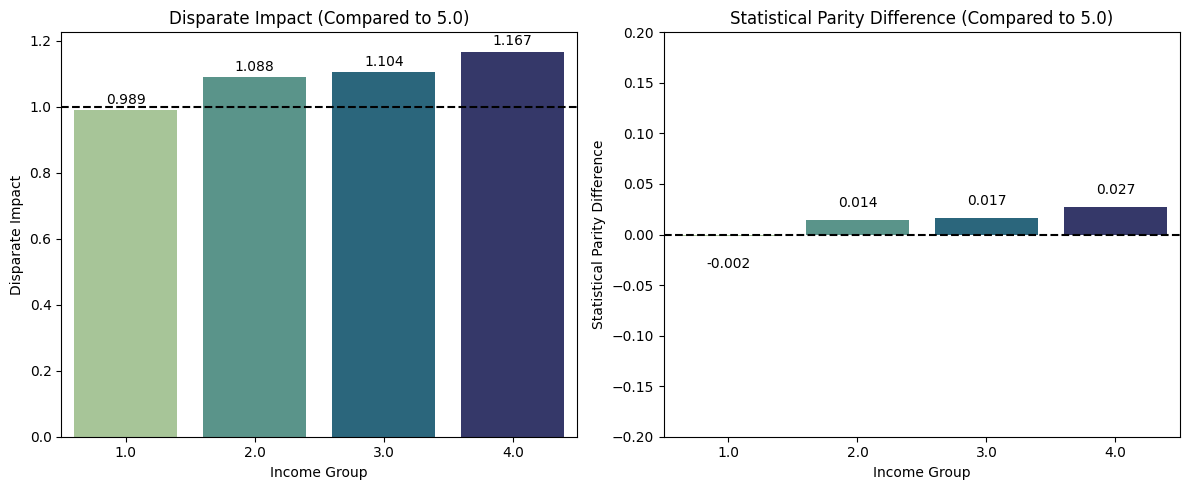

In [11]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_lr_weighted_fair_fam_inc')
plot_fairness_metrics(results, 'Income Group', 5.0)

### Fairness Constrain on Tier

In [12]:
mitigator = ExponentiatedGradient(
    LogisticRegression(max_iter=1000, C=1, class_weight={0: 10, 1: 1}),
    constraints=DemographicParity()
)

#mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])
mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])
y_pred = mitigator.predict(X_test)

In [13]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 132   95]
 [ 791 3397]]
              precision    recall  f1-score   support

           0       0.14      0.58      0.23       227
           1       0.97      0.81      0.88      4188

    accuracy                           0.80      4415
   macro avg       0.56      0.70      0.56      4415
weighted avg       0.93      0.80      0.85      4415



It seems that forcing parity over the tier feasture introduces some unabalancing in the model. But let's see if the we managed to remove the bias.

In [14]:
pass_bar_lr_weighted_fair_tier = mitigator.predict(df[features])
df['pass_bar_lr_weighted_fair_tier'] = pass_bar_lr_weighted_fair_tier

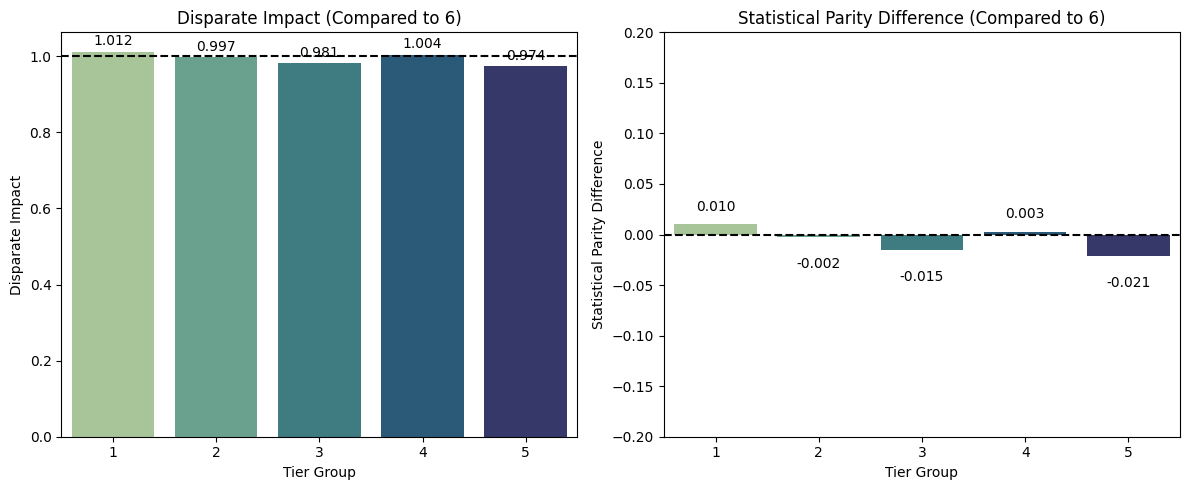

In [15]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df, 'tier', 6, 'pass_bar_lr_weighted_fair_tier')
plot_fairness_metrics(results, 'Tier Group', 6)

### Fairness Constrain on Race

In [49]:
features_race1 = features.copy()
features_race1.append('race1')

In [414]:
sensitive_race_train = df.loc[X_train.index, 'race1']

In [51]:
mitigator = ExponentiatedGradient(
    LogisticRegression(max_iter=1000, C=1, class_weight={0: 10, 1: 1}),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=sensitive_race_train)
y_pred = mitigator.predict(X_test)

In [52]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  76  151]
 [ 425 3763]]
              precision    recall  f1-score   support

           0       0.15      0.33      0.21       227
           1       0.96      0.90      0.93      4188

    accuracy                           0.87      4415
   macro avg       0.56      0.62      0.57      4415
weighted avg       0.92      0.87      0.89      4415



In [53]:
pass_bar_lr_weighted_fair_race = mitigator.predict(df[features])
df['pass_bar_lr_weighted_fair_race'] = pass_bar_lr_weighted_fair_race

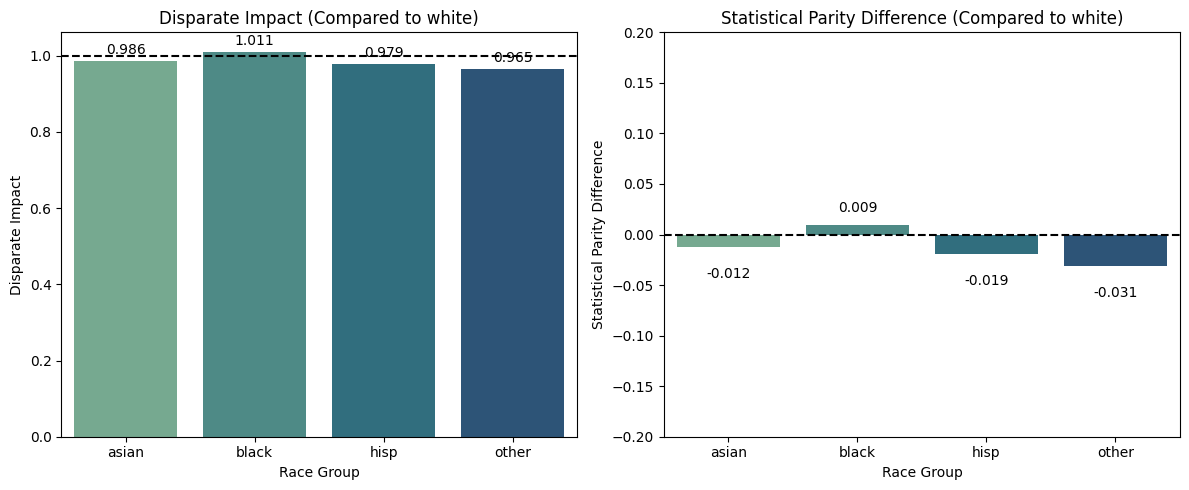

In [54]:
race_groups = ['hisp', 'asian', 'black', 'other']
results = get_DI_SPD_WD(race_groups, df, 'race1', 'white', 'pass_bar_lr_weighted_fair_race')
plot_fairness_metrics(results, 'Race Group', 'white')

### Fairness Constraint on fam_inc, tier and race

In [8]:
sensitive_faf_inc_race_tier_train = df.loc[X_train.index, ['race1', 'fam_inc', 'tier']]

In [22]:
mitigator = ExponentiatedGradient(
    LogisticRegression(max_iter=1000, C=1, class_weight={0: 10, 1: 1}),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=sensitive_faf_inc_race_tier_train)
y_pred = mitigator.predict(X_test)

In [23]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 202   25]
 [3755  433]]
              precision    recall  f1-score   support

           0       0.05      0.89      0.10       227
           1       0.95      0.10      0.19      4188

    accuracy                           0.14      4415
   macro avg       0.50      0.50      0.14      4415
weighted avg       0.90      0.14      0.18      4415



In [24]:
pass_bar_lr_weighted_fair_race_tier_fam_inc = mitigator.predict(df[features])
df['pass_bar_lr_weighted_fair_race_tier_fam_inc'] = pass_bar_lr_weighted_fair_race_tier_fam_inc

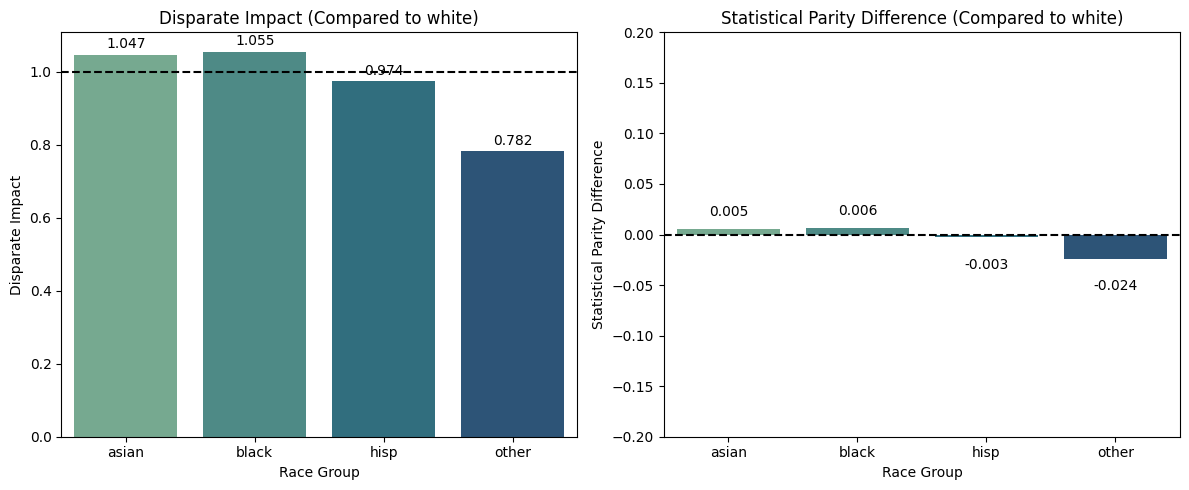

In [25]:
results_race = get_DI_SPD_WD(race_groups, df, 'race1', 'white', 'pass_bar_lr_weighted_fair_race_tier_fam_inc')
plot_fairness_metrics(results_race, 'Race Group', 'white')

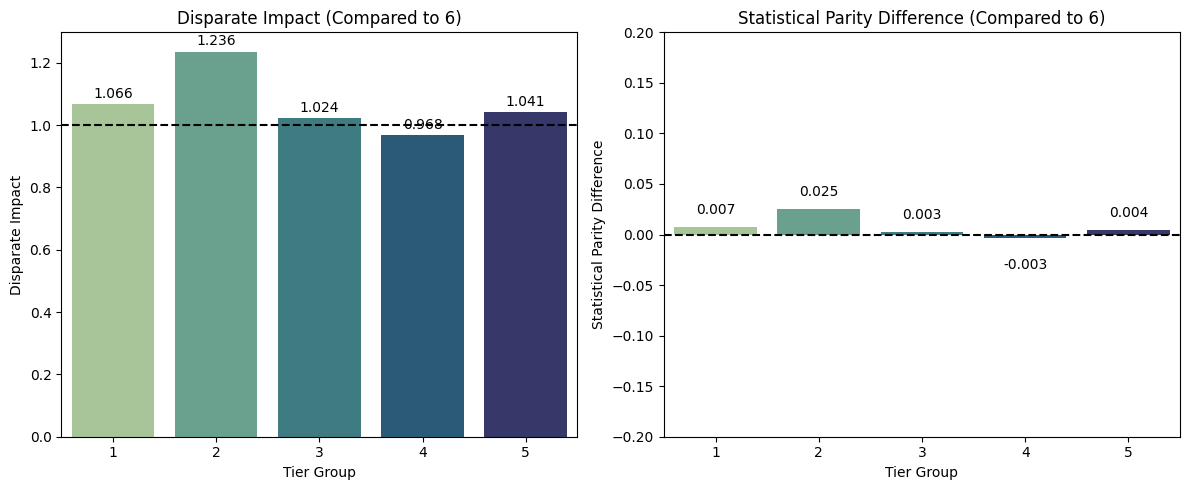

In [26]:
results_tier = get_DI_SPD_WD(tier_groups, df, 'tier', 6, 'pass_bar_lr_weighted_fair_race_tier_fam_inc')
plot_fairness_metrics(results_tier, 'Tier Group', 6)

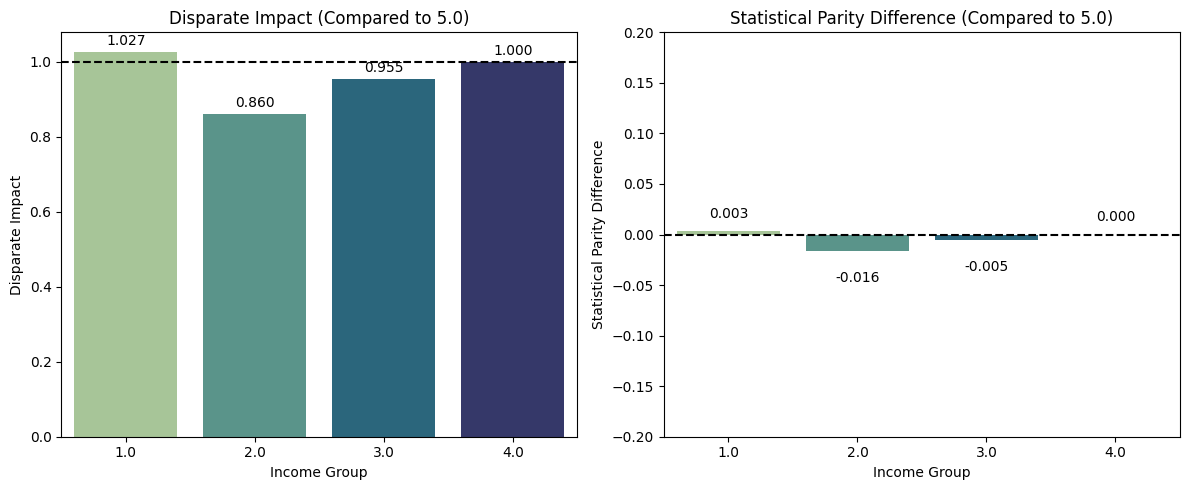

In [27]:
results_fam_inc = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_lr_weighted_fair_race_tier_fam_inc')
plot_fairness_metrics(results_fam_inc, 'Income Group', 5.0)

In [28]:
print(confusion_matrix(df['pass_bar'], df['pass_bar_lr_weighted_fair_race_tier_fam_inc']))
print(classification_report(df['pass_bar'], df['pass_bar_lr_weighted_fair_race_tier_fam_inc']))

[[ 1018   121]
 [18608  2325]]
              precision    recall  f1-score   support

           0       0.05      0.89      0.10      1139
           1       0.95      0.11      0.20     20933

    accuracy                           0.15     22072
   macro avg       0.50      0.50      0.15     22072
weighted avg       0.90      0.15      0.19     22072



It's clear that removing the bias associated with all three features causes the model to lose the criteria it previously used to distinguish between students who pass and those who don't. This proves that the dataset was biased, and the only way a model has to learn the relationship between the features and the label to identify students who don't pass is through biased features. 

## Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

### Fairness Constrain on Family Income

In [30]:
mitigator = ExponentiatedGradient(
    # Let's use the same parameters as the best model we previously trained
    RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', min_samples_leaf=2, max_depth=8, min_samples_split=10),
    constraints=DemographicParity()
)

# Fit model with fairness constraint on fam_income
mitigator.fit(X_train, y_train, sensitive_features=X_train['fam_inc'])

# Predict on test set
y_pred = mitigator.predict(X_test)

In [31]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 150   77]
 [ 688 3500]]
              precision    recall  f1-score   support

           0       0.18      0.66      0.28       227
           1       0.98      0.84      0.90      4188

    accuracy                           0.83      4415
   macro avg       0.58      0.75      0.59      4415
weighted avg       0.94      0.83      0.87      4415



In [32]:
pass_bar_rf_fair_fam_inc = mitigator.predict(df[features])
df['pass_bar_rf_fair_fam_inc'] = pass_bar_rf_fair_fam_inc

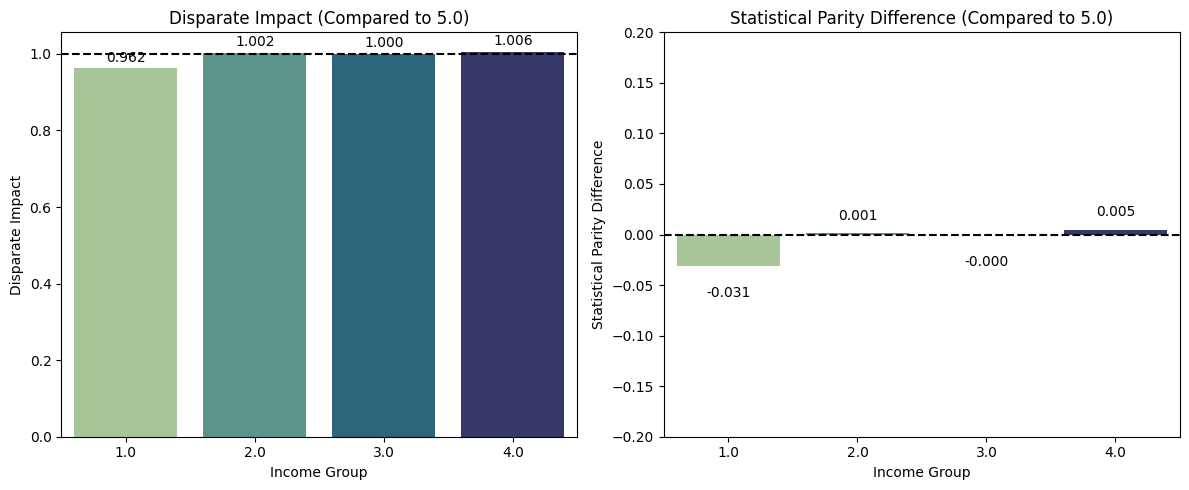

In [33]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_rf_fair_fam_inc')
plot_fairness_metrics(results, 'Income Group', 5.0)

### Fairness Constrain on Tier

In [34]:
mitigator = ExponentiatedGradient(
    RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', min_samples_leaf=2, max_depth=8, min_samples_split=10),
    constraints=DemographicParity()
)

#mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])
mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])
y_pred = mitigator.predict(X_test)

In [35]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 137   90]
 [ 630 3558]]
              precision    recall  f1-score   support

           0       0.18      0.60      0.28       227
           1       0.98      0.85      0.91      4188

    accuracy                           0.84      4415
   macro avg       0.58      0.73      0.59      4415
weighted avg       0.93      0.84      0.88      4415



In [36]:
pass_bar_rf_fair_tier = mitigator.predict(df[features])
df['pass_bar_rf_fair_tier'] = pass_bar_rf_fair_tier

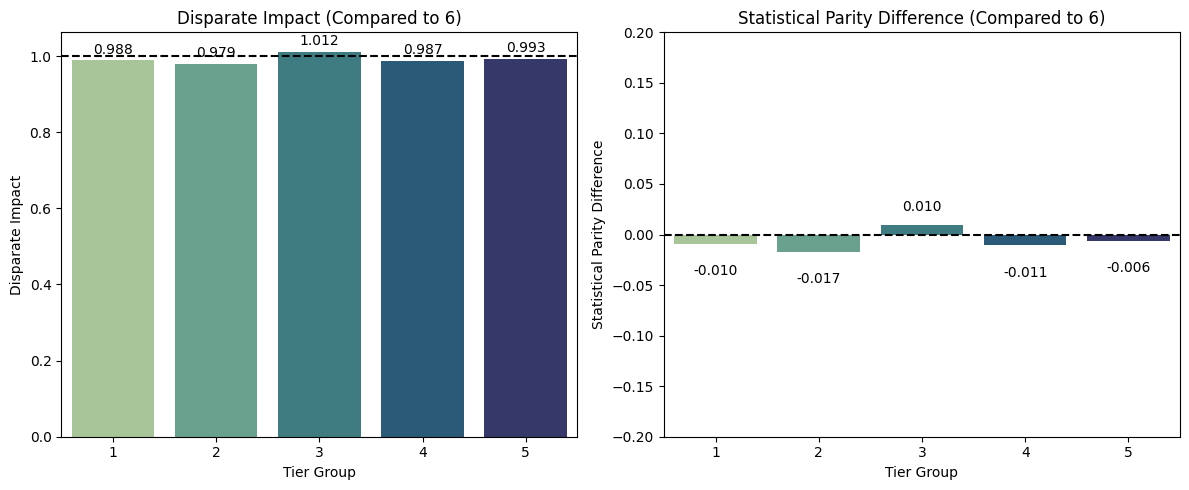

In [37]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df, 'tier', 6, 'pass_bar_rf_fair_tier')
plot_fairness_metrics(results, 'Tier Group', 6)

### Fairness Constrain on Race

In [38]:
mitigator = ExponentiatedGradient(
    RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', min_samples_leaf=2, max_depth=8, min_samples_split=10),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=sensitive_race_train)
y_pred = mitigator.predict(X_test)

In [39]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  75  152]
 [ 533 3655]]
              precision    recall  f1-score   support

           0       0.12      0.33      0.18       227
           1       0.96      0.87      0.91      4188

    accuracy                           0.84      4415
   macro avg       0.54      0.60      0.55      4415
weighted avg       0.92      0.84      0.88      4415



In [40]:
pass_bar_rf_fair_race = mitigator.predict(df[features])
df['pass_bar_rf_fair_race'] = pass_bar_rf_fair_race

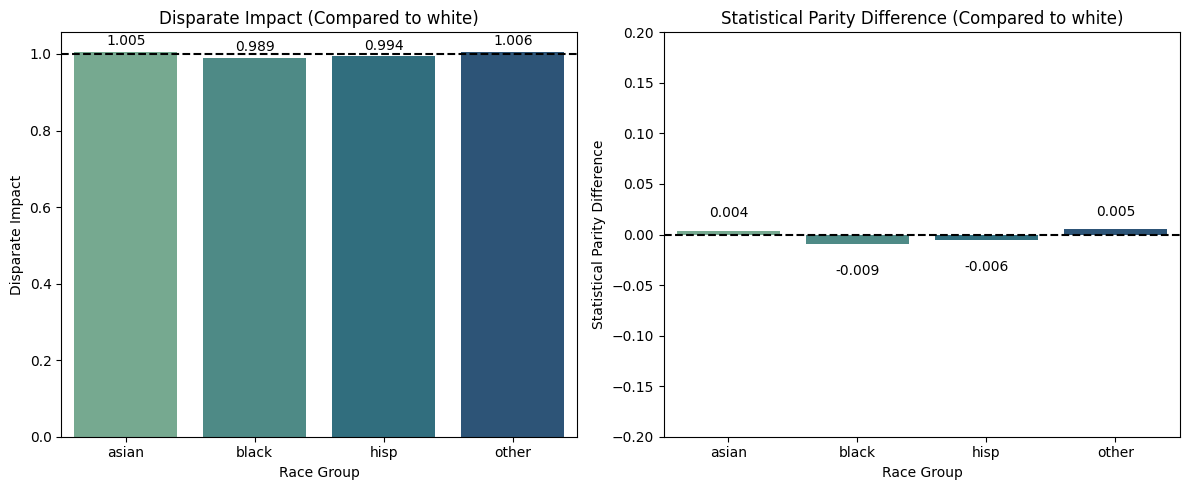

In [41]:
results = get_DI_SPD_WD(race_groups, df, 'race1', 'white', 'pass_bar_rf_fair_race')
plot_fairness_metrics(results, 'Race Group', 'white')

### Fairness Constraints on fam_inc, race and tier

In [9]:
mitigator = ExponentiatedGradient(
    RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', min_samples_leaf=2, max_depth=8, min_samples_split=10),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=sensitive_faf_inc_race_tier_train)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x13b6a7ad0>,
                      estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=8,
                                                       min_samples_leaf=2,
                                                       min_samples_split=10,
                                                       n_estimators=50,
                                                       random_state=42),
                      nu=0.00137730402772624)

In [10]:
y_pred = mitigator.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  98  129]
 [ 811 3377]]
              precision    recall  f1-score   support

           0       0.11      0.43      0.17       227
           1       0.96      0.81      0.88      4188

    accuracy                           0.79      4415
   macro avg       0.54      0.62      0.53      4415
weighted avg       0.92      0.79      0.84      4415



In [11]:
pass_bar_rf_weighted_fair_race_tier_fam_inc = mitigator.predict(df[features])
df['pass_bar_rf_weighted_fair_race_tier_fam_inc'] = pass_bar_rf_weighted_fair_race_tier_fam_inc

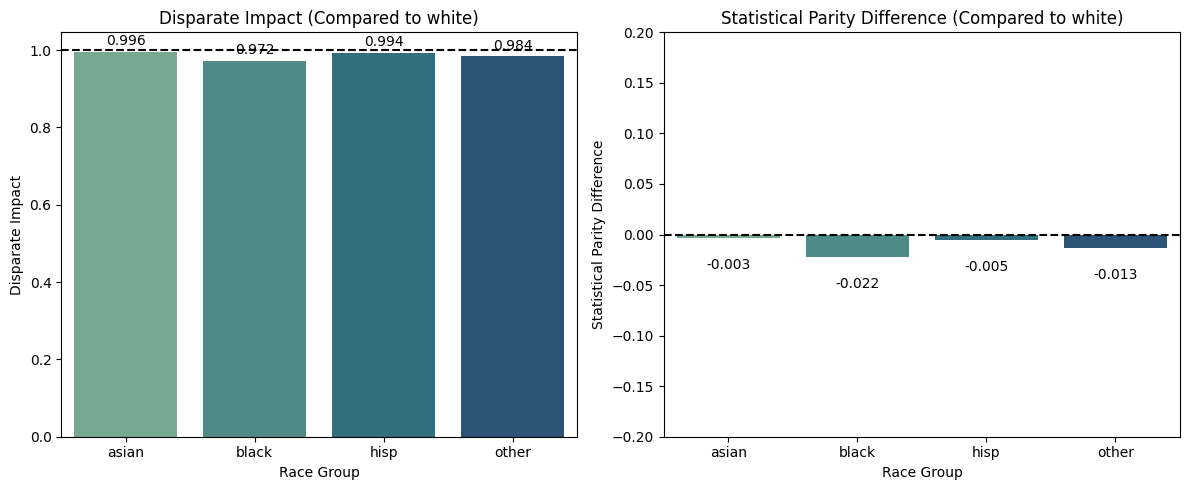

In [15]:
race_groups = ['hisp', 'asian', 'black', 'other']
results = get_DI_SPD_WD(race_groups, df, 'race1', 'white', 'pass_bar_rf_weighted_fair_race_tier_fam_inc')

plot_fairness_metrics(results, 'Race Group', 'white')

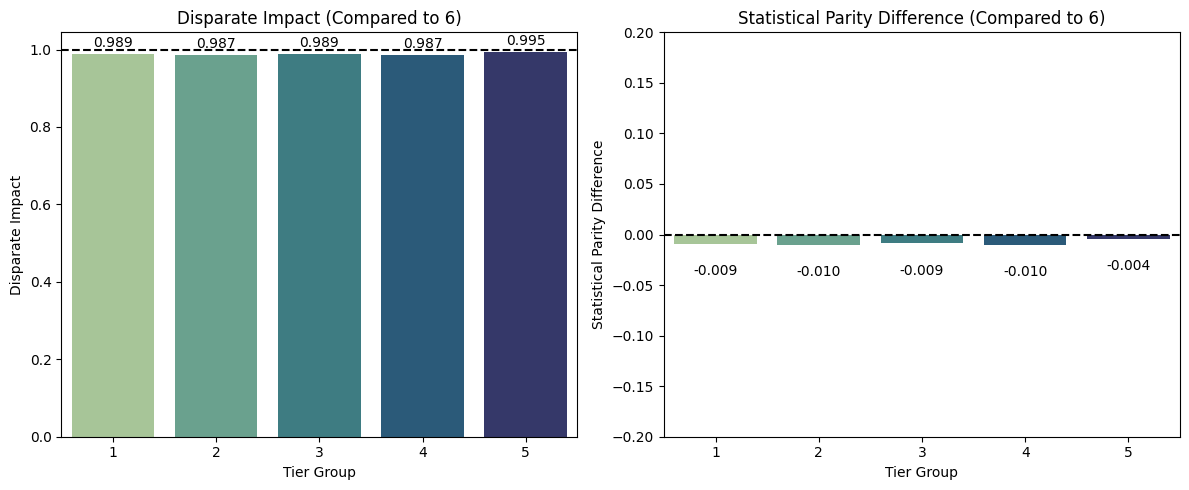

In [17]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df, 'tier', 6, 'pass_bar_rf_weighted_fair_race_tier_fam_inc')
plot_fairness_metrics(results, 'Tier Group', 6)

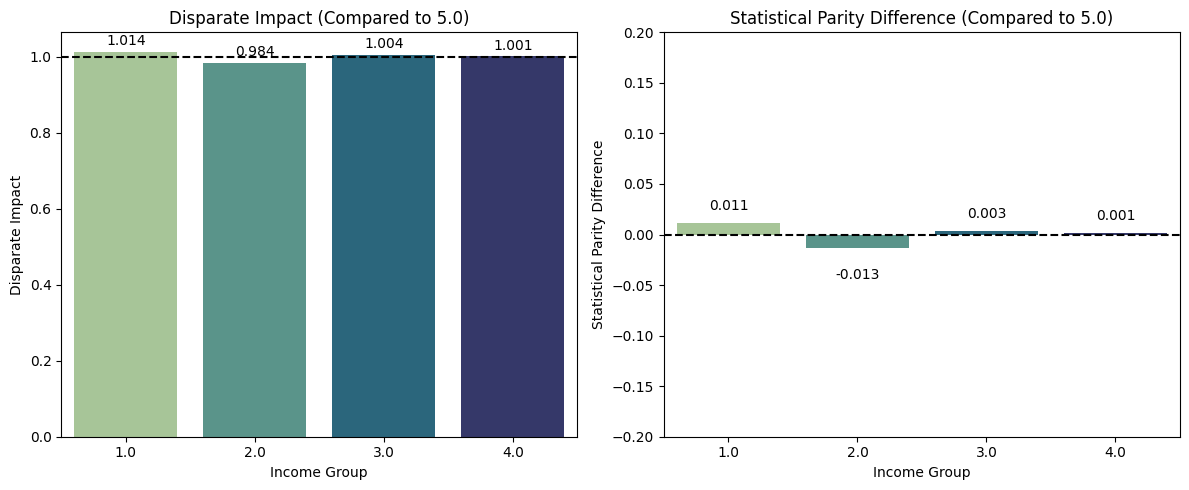

In [18]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_rf_weighted_fair_race_tier_fam_inc')
plot_fairness_metrics(results, 'Income Group', 5.0)

##  XGBoost

In [20]:
from xgboost import XGBClassifier

ratio = np.sum(y_train == 0) / np.sum(y_train == 1)

### Fairness Constraint on fam_inc

In [89]:
mitigator = ExponentiatedGradient(
    # Let's use the same parameters as the best model we previously trained
    XGBClassifier(eval_metric='logloss', scale_pos_weight=ratio, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200),
    constraints=DemographicParity()
)

# Fit model with fairness constraint on fam_income
mitigator.fit(X_train, y_train, sensitive_features=X_train['fam_inc'])

# Predict on test set
y_pred = mitigator.predict(X_test)

In [90]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 158   69]
 [ 709 3479]]
              precision    recall  f1-score   support

           0       0.18      0.70      0.29       227
           1       0.98      0.83      0.90      4188

    accuracy                           0.82      4415
   macro avg       0.58      0.76      0.59      4415
weighted avg       0.94      0.82      0.87      4415



In [91]:
pass_bar_xgb_fair_fam_inc = mitigator.predict(df[features])
df['pass_bar_xgb_fair_fam_inc'] = pass_bar_xgb_fair_fam_inc

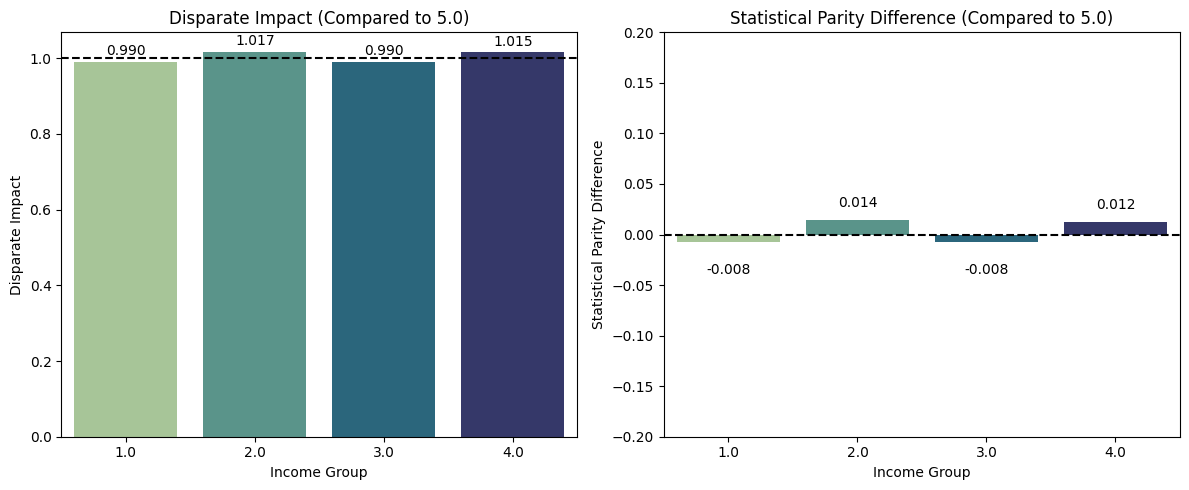

In [92]:
results = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_xgb_fair_fam_inc')
plot_fairness_metrics(results, 'Income Group', 5.0)

### Fairness Constraint on Tier

In [93]:
mitigator = ExponentiatedGradient(
    # Let's use the same parameters as the best model we previously trained
    XGBClassifier(eval_metric='logloss', scale_pos_weight=ratio, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200),
    constraints=DemographicParity()
)

# Fit model with fairness constraint on fam_income
mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])

# Predict on test set
y_pred = mitigator.predict(X_test)

In [94]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 150   77]
 [ 680 3508]]
              precision    recall  f1-score   support

           0       0.18      0.66      0.28       227
           1       0.98      0.84      0.90      4188

    accuracy                           0.83      4415
   macro avg       0.58      0.75      0.59      4415
weighted avg       0.94      0.83      0.87      4415



In [95]:
pass_bar_xgb_fair_tier = mitigator.predict(df[features])
df['pass_bar_xgb_fair_tier'] = pass_bar_xgb_fair_tier

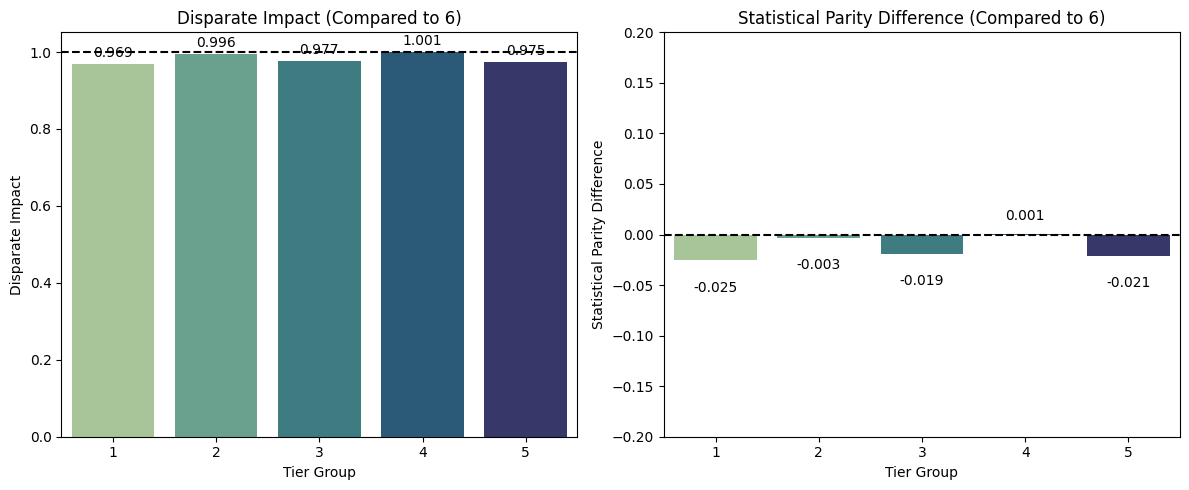

In [96]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df, 'tier', 6, 'pass_bar_xgb_fair_tier')
plot_fairness_metrics(results, 'Tier Group', 6)

### Fairness Constraint on Race

In [97]:
mitigator = ExponentiatedGradient(
    XGBClassifier(eval_metric='logloss', scale_pos_weight=ratio, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=sensitive_race_train)
y_pred = mitigator.predict(X_test)

In [98]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  67  160]
 [ 475 3713]]
              precision    recall  f1-score   support

           0       0.12      0.30      0.17       227
           1       0.96      0.89      0.92      4188

    accuracy                           0.86      4415
   macro avg       0.54      0.59      0.55      4415
weighted avg       0.92      0.86      0.88      4415



In [99]:
pass_bar_xgb_fair_race = mitigator.predict(df[features])
df['pass_bar_xgb_fair_race'] = pass_bar_xgb_fair_race

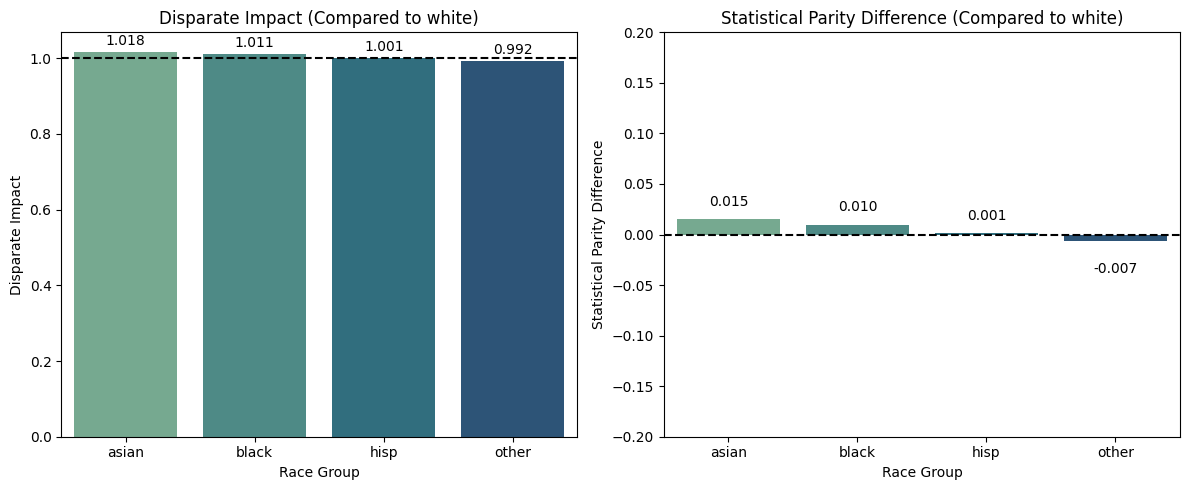

In [100]:
results = get_DI_SPD_WD(race_groups, df, 'race1', 'white', 'pass_bar_xgb_fair_race')
plot_fairness_metrics(results, 'Race Group', 'white')

### Fairness Constraints on fam_inc, race and tier

In [21]:
mitigator = ExponentiatedGradient(
    XGBClassifier(eval_metric='logloss', scale_pos_weight=ratio, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=sensitive_faf_inc_race_tier_train)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x1428c0740>,
                      estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_typ...
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.01, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None, ...),
                      nu=0.0014872276599908157)

In [22]:
y_pred = mitigator.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 108  119]
 [ 998 3190]]
              precision    recall  f1-score   support

           0       0.10      0.48      0.16       227
           1       0.96      0.76      0.85      4188

    accuracy                           0.75      4415
   macro avg       0.53      0.62      0.51      4415
weighted avg       0.92      0.75      0.82      4415



In [23]:
pass_bar_xgb_weighted_fair_race_tier_fam_inc = mitigator.predict(df[features])
df['pass_bar_xgb_weighted_fair_race_tier_fam_inc'] = pass_bar_xgb_weighted_fair_race_tier_fam_inc

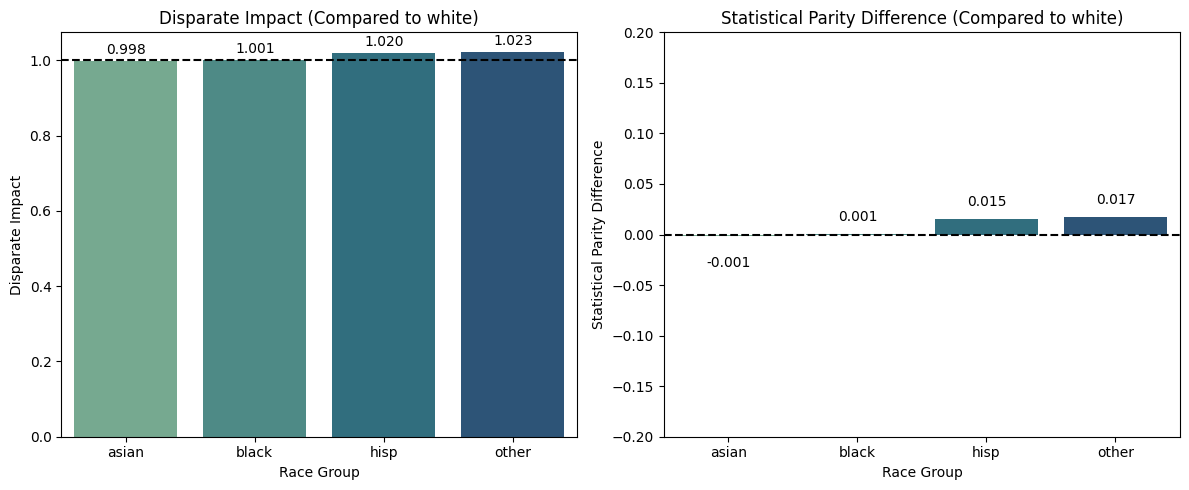

In [24]:
results = get_DI_SPD_WD(race_groups, df, 'race1', 'white', 'pass_bar_xgb_weighted_fair_race_tier_fam_inc')
plot_fairness_metrics(results, 'Race Group', 'white')

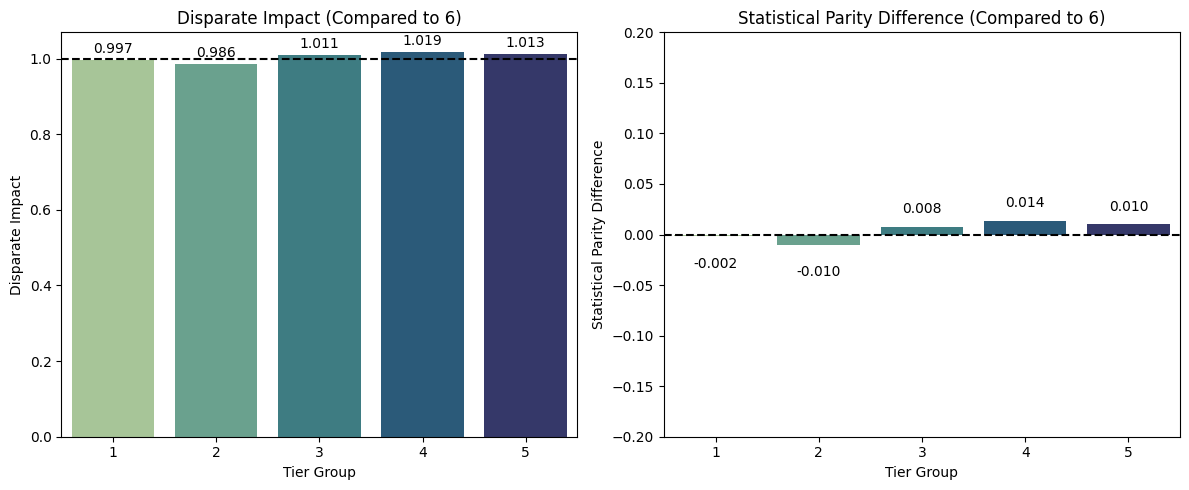

In [25]:
results = get_DI_SPD_WD(tier_groups, df, 'tier', 6, 'pass_bar_xgb_weighted_fair_race_tier_fam_inc')
plot_fairness_metrics(results, 'Tier Group', 6)

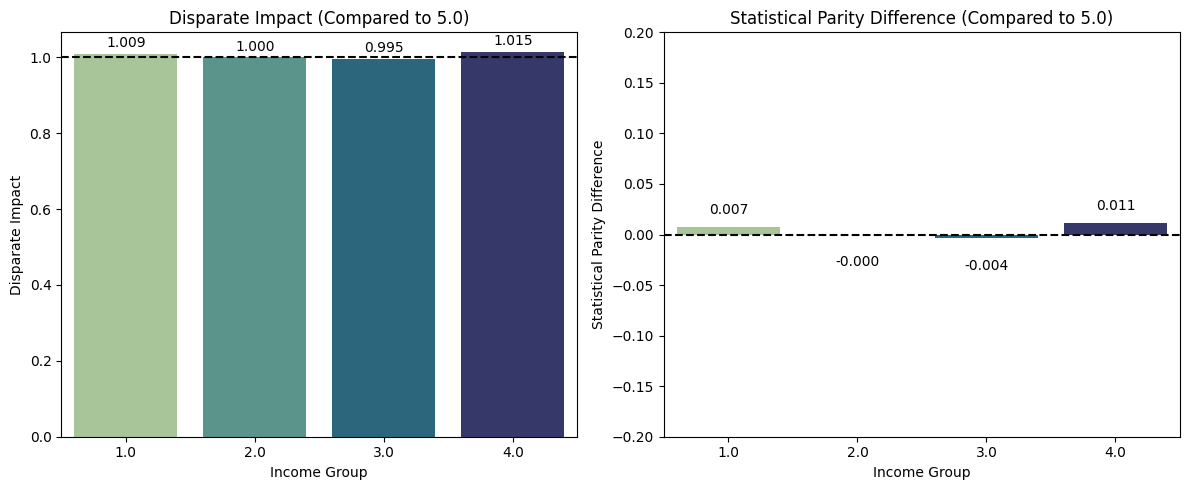

In [26]:
results = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_xgb_weighted_fair_race_tier_fam_inc')
plot_fairness_metrics(results, 'Income Group', 5.0)


## MLP

In [398]:
import random
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X_train_idx = X_train.index
X_test_idx = X_test.index

# Python random seed for reproducability
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [399]:
numeric_features = ['decile1', 'decile3', 'lsat', 'ugpa', 'fam_inc', 'zfygpa', 'zgpa']
pass_through_features = ['male', 'parttime', 'tier', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', pass_through_features)
    ]
)


# Fit and transform
X_train_mlp = preprocessor.fit_transform(X_train)
X_test_mlp = preprocessor.transform(X_test)

X_train_mlp = np.array(X_train_mlp).astype(np.float32)
X_test_mlp = np.array(X_test_mlp).astype(np.float32)

In [400]:
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'X': X_train_mlp,
        'fam_inc': df.loc[X_train_idx, 'fam_inc'].values,
        'tier': df.loc[X_train_idx, 'tier'].values,
        'race1': df.loc[X_train_idx, 'race1'].values
    },
    y_train.values
)).shuffle(1024).batch(32)

num_samples = len(X_train_mlp)
train_samples = int(0.8 * num_samples)
batch_size = 32
num_train_batches = train_samples // batch_size

train_dataset = dataset.take(num_train_batches)
val_dataset = dataset.skip(num_train_batches)


----------------------------------------------------------------------------------------------------------------

--------------------------------------------------------

In [401]:
unique_groups_dict = {
    'fam_inc': [1,2,3,4,5],
    'tier': [1,2,3,4,5,6],
    'race1': ['asian', 'black', 'hisp', 'other']
}

reference_values = {
    'fam_inc': 5,     
    'tier': 6,         
    'race1': 'white'   
}

In [402]:
def reference_group_parity_penalty(y_true, y_pred, feature_values, reference_value, unique_groups):
    ref_mask = tf.equal(feature_values, reference_value)
    ref_preds = tf.boolean_mask(y_pred, ref_mask)

    def no_ref():
        return tf.constant(0.0)

    def compute_penalty():
        penalty = tf.constant(0.0, dtype=tf.float32)
        ref_mean = tf.reduce_mean(ref_preds)

        for group in unique_groups:
            if group == reference_value:
                continue

            mask = tf.equal(feature_values, group)
            group_preds = tf.boolean_mask(y_pred, mask)

            def no_group():
                return tf.constant(0.0)

            def group_diff():
                group_mean = tf.reduce_mean(group_preds)
                return tf.abs(group_mean - ref_mean)

            group_penalty = tf.cond(
                tf.equal(tf.size(group_preds), 0),
                no_group,
                group_diff
            )
            penalty += group_penalty

        return penalty

    return tf.cond(tf.equal(tf.size(ref_preds), 0), no_ref, compute_penalty)


In [403]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# --------- Focal Loss Function ---------
'''def focal_loss(gamma=0, alpha=0.5):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1. - 1e-7)  # Increased epsilon

        # Compute p_t
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)

        # Compute focal loss
        loss = -tf.where(tf.equal(y_true, 1),
                         alpha * tf.pow(1 - pt, gamma) * tf.math.log(pt),
                         (1 - alpha) * tf.pow(pt, gamma) * tf.math.log(1 - pt))

        return loss
    return focal_loss_fixed'''

def focal_loss(gamma=0, alpha=0.5):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        
        # Match Keras' internal numerical stability handling
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        
        # Compute p_t (probability of true class)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        
        # Focal term: (1 - pt)^gamma
        focal_term = tf.pow(1 - pt, gamma)
        
        # Cross-entropy term: -log(pt)
        ce = -tf.math.log(pt)
        
        # Balanced weighting: alpha for class 1, (1-alpha) for class 0
        alpha_weight = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        
        # Final loss
        loss = alpha_weight * focal_term * ce
        
        return loss
    return focal_loss_fixed

# --------- Model Definition ---------
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_mlp.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam()
loss_fn = focal_loss()
class_weights = {0: 40, 1: 1}
weight_tensor = tf.constant([class_weights[0], class_weights[1]], dtype=tf.float32)

# --------- Training and Validation Steps ---------
'''@tf.function
def train_step(x_batch, y_batch):
    X_input = x_batch['X']
    y_batch = tf.cast(y_batch, tf.float32)

    with tf.GradientTape() as tape:
        y_pred = model(X_input, training=True)
        sample_weights = tf.gather(weight_tensor, tf.cast(y_batch, tf.int32))
        per_sample_loss = loss_fn(y_batch, y_pred)
        weighted_loss = tf.reduce_mean(per_sample_loss * sample_weights)

    grads = tape.gradient(weighted_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return weighted_loss'''

@tf.function
def train_step(x_batch, y_batch):
    X_input = x_batch['X']
    y_batch = tf.cast(y_batch, tf.float32)

    with tf.GradientTape() as tape:
        y_pred = model(X_input, training=True)
        
        sample_weights = tf.gather(weight_tensor, tf.cast(y_batch, tf.int32))
        per_sample_loss = loss_fn(y_batch, y_pred)
        weighted_loss = tf.reduce_mean(per_sample_loss * sample_weights)


        penalty = tf.constant(0.0, dtype=tf.float32)
        for feature_name in ['fam_inc', 'tier', 'race1']:
            feature_values = x_batch[feature_name]
            penalty += reference_group_parity_penalty(
                y_true=y_batch,
                y_pred=y_pred,
                feature_values=feature_values,
                reference_value=reference_values[feature_name],
                unique_groups=unique_groups_dict[feature_name]
            )
        lambda_penalty = 0.01  
        total_loss = weighted_loss + lambda_penalty * penalty

    # 4. Compute gradients and update
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss  # Return original loss (optional: return total_loss)

@tf.function
def val_step(x_batch, y_batch):
    X_input = x_batch['X']
    y_batch = tf.cast(y_batch, tf.float32)
    #tf.print('y_batch', y_batch)
    y_pred = model(X_input, training=False)
    #tf.print('y_pred', y_pred)
    sample_weights = tf.gather(weight_tensor, tf.cast(y_batch, tf.int32))
    per_sample_loss = loss_fn(y_batch, y_pred)
    weighted_loss = tf.reduce_mean(per_sample_loss * sample_weights)
    return weighted_loss

# --------- Custom Training Loop ---------
patience = 10
best_val_loss = float('inf')
wait = 0
best_weights = None

for epoch in range(50):
    print(f"\nEpoch {epoch + 1}/100")
    # Training
    train_loss_avg = tf.keras.metrics.Mean()
    for x_batch, y_batch in train_dataset:
        loss = train_step(x_batch, y_batch)
        train_loss_avg.update_state(loss)
    train_loss = train_loss_avg.result()
    print(f"Train loss: {train_loss:.4f}")

    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    for x_batch, y_batch in val_dataset:
        loss = val_step(x_batch, y_batch)
        val_loss_avg.update_state(loss)
    val_loss = val_loss_avg.result()
    print(f"Validation loss: {val_loss}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        best_weights = model.get_weights()
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping. Restoring best weights.")
            model.set_weights(best_weights)
            break


/Users/federicomarchi/.pyenv/versions/3.12.4/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/100


2025-06-10 12:18:16.940667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 1.0649


2025-06-10 12:18:17.519946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 0.9257432222366333

Epoch 2/100


2025-06-10 12:18:19.359104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.9706


2025-06-10 12:18:19.706474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 0.918919563293457

Epoch 3/100


2025-06-10 12:18:21.551374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.9641


2025-06-10 12:18:21.937188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 0.925356388092041

Epoch 4/100


2025-06-10 12:18:23.850359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.9556


2025-06-10 12:18:24.215367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 0.9042738080024719

Epoch 5/100


2025-06-10 12:18:26.042755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.9599


2025-06-10 12:18:26.410265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 0.9235441088676453

Epoch 6/100


2025-06-10 12:18:28.272374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.9538


2025-06-10 12:18:28.699304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 0.9156405329704285

Epoch 7/100


2025-06-10 12:18:30.539249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.9493


2025-06-10 12:18:30.918701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 0.9129942059516907

Epoch 8/100


2025-06-10 12:18:32.888678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.9556


2025-06-10 12:18:33.279866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 0.930509626865387

Epoch 9/100


2025-06-10 12:18:35.108745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.9515


2025-06-10 12:18:35.458107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 0.9244312047958374

Epoch 10/100


2025-06-10 12:18:37.280525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.9519


2025-06-10 12:18:37.634690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 0.9187483191490173

Epoch 11/100


2025-06-10 12:18:39.468260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.9512


2025-06-10 12:18:39.817235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 0.9112684726715088

Epoch 12/100


2025-06-10 12:18:41.622478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.9480


2025-06-10 12:18:41.999035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 0.9078333973884583

Epoch 13/100


2025-06-10 12:18:43.830513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.9515


2025-06-10 12:18:44.193561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 0.9138456583023071

Epoch 14/100


2025-06-10 12:18:46.021461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.9520
Validation loss: 0.9215909242630005
Early stopping. Restoring best weights.


2025-06-10 12:18:46.374029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [404]:
y_test_pred = model.predict(X_test)
y_test_pred = (y_test_pred >= 0.5).astype(int)

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [412]:
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[   8  219]
 [ 145 4043]]
              precision    recall  f1-score   support

           0       0.05      0.04      0.04       227
           1       0.95      0.97      0.96      4188

    accuracy                           0.92      4415
   macro avg       0.50      0.50      0.50      4415
weighted avg       0.90      0.92      0.91      4415



In [410]:
y_pred_all = model.predict(df[features])
y_pred_all = (y_pred_all >= 0.5).astype(int)

pass_bar_mlp_fair_fam_inc_race_tier = y_pred_all
df['pass_bar_mlp_fair_fam_inc_race_tier'] = pass_bar_mlp_fair_fam_inc_race_tier

690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step


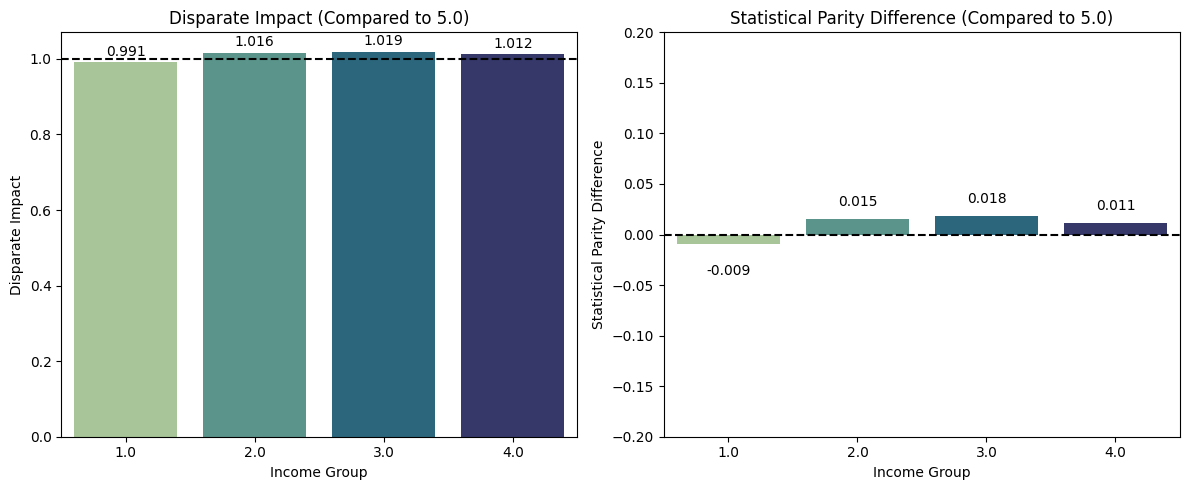

In [411]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_mlp_fair_fam_inc_race_tier')
plot_fairness_metrics(results, 'Income Group', 5.0)

In [408]:
print(confusion_matrix(df[target], y_pred_all))


[[   57  1082]
 [  780 20153]]


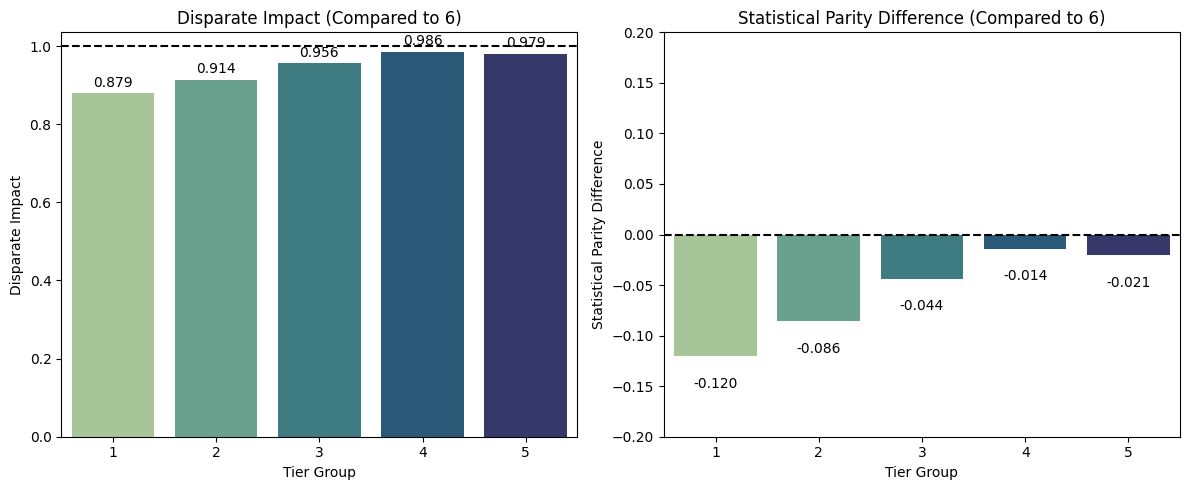

In [413]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df, 'tier', 6, 'pass_bar_mlp_fair_fam_inc_race_tier')
plot_fairness_metrics(results, 'Tier Group', 6)

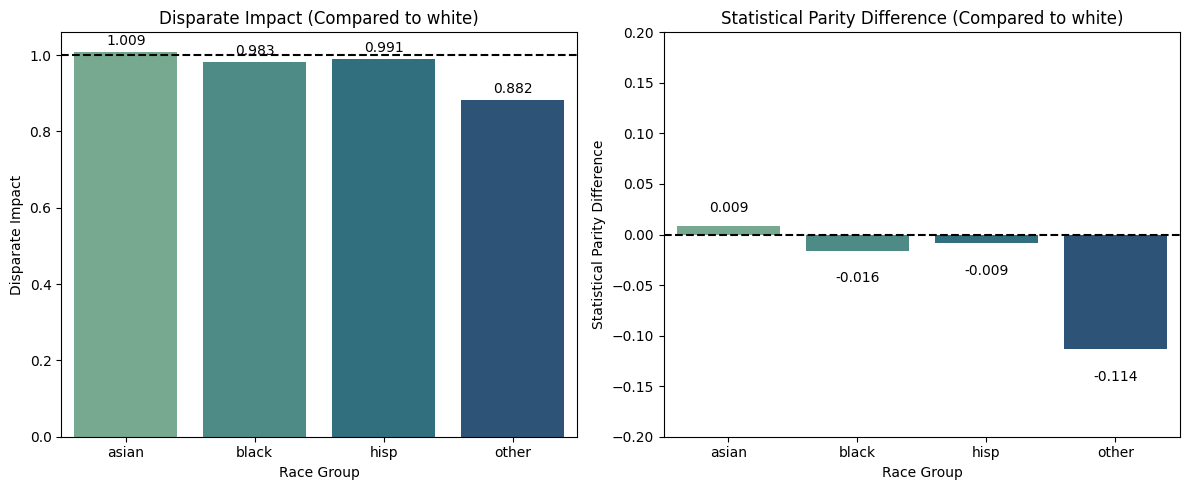

In [416]:
race_groups = ['hisp', 'asian', 'black', 'other']
results = get_DI_SPD_WD(race_groups, df, 'race1', 'white', 'pass_bar_mlp_fair_fam_inc_race_tier')
plot_fairness_metrics(results, 'Race Group', 'white')

We need to define a loss funciton which account for bias penalizing it.

We need to define a penalty that has to be added to the loss funciton, we will compute the **demographic parity penalty**. This penalty will be related to the difference in predected scores between sensitive groups, relative to a chosen privileged group.

In [386]:
def reference_group_parity_penalty(y_true, y_pred, feature_values, reference_value, unique_groups):
    ref_mask = tf.equal(feature_values, reference_value)
    ref_preds = tf.boolean_mask(y_pred, ref_mask)

    def no_ref():
        return tf.constant(0.0)

    def compute_penalty():
        penalty = tf.constant(0.0, dtype=tf.float32)
        ref_mean = tf.reduce_mean(ref_preds)

        for group in unique_groups:
            if group == reference_value:
                continue

            mask = tf.equal(feature_values, group)
            group_preds = tf.boolean_mask(y_pred, mask)

            def no_group():
                return tf.constant(0.0)

            def group_diff():
                group_mean = tf.reduce_mean(group_preds)
                return tf.abs(group_mean - ref_mean)

            group_penalty = tf.cond(
                tf.equal(tf.size(group_preds), 0),
                no_group,
                group_diff
            )
            penalty += group_penalty

        return penalty

    return tf.cond(tf.equal(tf.size(ref_preds), 0), no_ref, compute_penalty)


In [387]:
def combined_loss_fn(sensitive_features, reference_values, unique_groups_dict, lambda_fairness=1.0, gamma=2.0, alpha=0.25):
    focal_loss_fn = focal_loss(gamma=gamma, alpha=alpha)
    
    def loss(y_true, y_pred):
        focal = focal_loss_fn(y_true, y_pred)

        fairness_penalty = tf.constant(0.0, dtype=tf.float32)
        for feat_name, ref_value in reference_values.items():
            feature_tensor = sensitive_features[feat_name]
            pred = tf.reshape(y_pred, [-1])
            fairness_penalty += reference_group_parity_penalty(
                y_true,
                pred,
                feature_tensor,
                ref_value,
                unique_groups_dict[feat_name]
            )
        return focal + lambda_fairness * fairness_penalty
    
    return loss


In [388]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input, Model

input_dict = {
    'X': Input(shape=(X_train_mlp.shape[1],), name='X'),
}

x = Dense(128, activation='relu')(input_dict['X'])
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model_mlp = Model(inputs=input_dict, outputs=output)

In [389]:
unique_groups_dict = {
    'fam_inc': [1,2,3,4,5],
    'tier': [1,2,3,4,5,6],
    'race1': ['asian', 'black', 'hisp', 'other']
}

reference_values = {
    'fam_inc': 5,     
    'tier': 6,         
    'race1': 'white'   
}

In [264]:
'''loss_fn = combined_loss_fn(
    sensitive_features=sensitive_dict_train,
    reference_values=reference_values,
    unique_groups_dict=unique_groups_dict,
    lambda_fairness=1.0
)'''

'loss_fn = combined_loss_fn(\n    sensitive_features=sensitive_dict_train,\n    reference_values=reference_values,\n    unique_groups_dict=unique_groups_dict,\n    lambda_fairness=1.0\n)'

In [390]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        loss = -alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1 + 1e-9) - \
               (1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0 + 1e-9)
        return loss  # return per-sample loss, not reduced
    return focal_loss_fixed

In [168]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Create once, outside

@tf.function
def train_step(x_batch, y_batch, lambda_fairness, optimizer, loss_fn):
    with tf.GradientTape() as tape:
        y_pred = model_mlp({'X': x_batch['X']}, training=True)

        sensitive_batch = {
            'fam_inc': tf.convert_to_tensor(x_batch['fam_inc']),
            'tier': tf.convert_to_tensor(x_batch['tier']),
            'race1': tf.convert_to_tensor(x_batch['race1']),
        }

        #loss_value = tf.keras.losses.BinaryCrossentropy()(y_batch, tf.reshape(y_pred, [-1]))
        loss_value = loss_fn(y_batch, tf.reshape(y_pred, [-1]))

        fairness_penalty = tf.constant(0.0, dtype=tf.float32)

    
        for feat_name, ref_value in reference_values.items():
            fairness_penalty += reference_group_parity_penalty(
                y_true=y_batch,
                y_pred=tf.reshape(y_pred, [-1]),
                feature_values=sensitive_batch[feat_name],
                reference_value=ref_value,
                unique_groups=unique_groups_dict[feat_name]
            )
        total_loss = loss_value + lambda_fairness * fairness_penalty

    grads = tape.gradient(total_loss, model_mlp.trainable_weights)
    optimizer.apply_gradients(zip(grads, model_mlp.trainable_weights))

    return total_loss


In [397]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Create once, outside
class_weight_dict = {0: 100.0, 1: 0.1}

@tf.function
def train_step(x_batch, y_batch, lambda_fairness, optimizer, loss_fn):
    with tf.GradientTape() as tape:
        y_pred = model_mlp({'X': x_batch['X']}, training=True)

        unweighted_loss = loss_fn(y_batch, tf.reshape(y_pred, [-1]))
        
        weights = tf.where(tf.equal(y_batch, 0),
                           class_weight_dict[0],
                           class_weight_dict[1])
        
        sensitive_batch = {
            'fam_inc': tf.convert_to_tensor(x_batch['fam_inc']),
            'tier': tf.convert_to_tensor(x_batch['tier']),
            'race1': tf.convert_to_tensor(x_batch['race1']),
        }
        
        #loss_value = tf.keras.losses.BinaryCrossentropy()(y_batch, tf.reshape(y_pred, [-1]))
        weighted_loss = tf.reduce_mean(unweighted_loss * weights)
        
    grads = tape.gradient(weighted_loss, model_mlp.trainable_weights)
    optimizer.apply_gradients(zip(grads, model_mlp.trainable_weights))

    return weighted_loss


In [398]:
loss_fn = focal_loss(gamma=2.0, alpha=0.25)

for epoch in range(15):
    print('Epoch:', epoch)
    for x_batch, y_batch in dataset:
        total_loss = train_step(x_batch, y_batch, 0, optimizer, loss_fn)
    print('Loss Val:', total_loss)

Epoch: 0


2025-06-08 20:03:57.973934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.034742165, shape=(), dtype=float32)
Epoch: 1


2025-06-08 20:03:59.012376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.024826683, shape=(), dtype=float32)
Epoch: 2


2025-06-08 20:04:00.089666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.02938679, shape=(), dtype=float32)
Epoch: 3


2025-06-08 20:04:01.180405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.024612362, shape=(), dtype=float32)
Epoch: 4


2025-06-08 20:04:02.284108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.027756782, shape=(), dtype=float32)
Epoch: 5


2025-06-08 20:04:03.461692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.031196365, shape=(), dtype=float32)
Epoch: 6


2025-06-08 20:04:04.569094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.026507515, shape=(), dtype=float32)
Epoch: 7


2025-06-08 20:04:05.673793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.02641765, shape=(), dtype=float32)
Epoch: 8


2025-06-08 20:04:06.790865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.026450798, shape=(), dtype=float32)
Epoch: 9


2025-06-08 20:04:07.896812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.028167702, shape=(), dtype=float32)
Epoch: 10


2025-06-08 20:04:08.979180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.027646473, shape=(), dtype=float32)
Epoch: 11


2025-06-08 20:04:10.140039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.02821528, shape=(), dtype=float32)
Epoch: 12


2025-06-08 20:04:11.276006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.027506681, shape=(), dtype=float32)
Epoch: 13


2025-06-08 20:04:12.350668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss Val: tf.Tensor(0.023214482, shape=(), dtype=float32)
Epoch: 14
Loss Val: tf.Tensor(0.022098757, shape=(), dtype=float32)


2025-06-08 20:04:13.303245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [399]:
y_test_pred = model_mlp.predict(X_test)
y_test_pred = (y_test_pred >= 0.58).astype(int)

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [400]:
print(confusion_matrix(y_test, y_test_pred))

[[   0  227]
 [   0 4188]]


In [367]:
pass_bar_mlp_fair_fam_inc_race_tier = model_mlp.predict(df[features])
pass_bar_mlp_fair_fam_inc_race_tier = (pass_bar_mlp_fair_fam_inc_race_tier >= 0.58).astype(int)

print(confusion_matrix(df['pass_bar'], pass_bar_mlp_fair_fam_inc_race_tier))

690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step
[[    0  1139]
 [    0 20933]]


In [296]:
pass_bar_mlp_fair_fam_inc_race_tier = model_mlp.predict(df[features])
pass_bar_mlp_fair_fam_inc_race_tier = (pass_bar_mlp_fair_fam_inc_race_tier >= 0.58).astype(int)

df['pass_bar_mlp_fair_fam_inc_race_tier'] = pass_bar_mlp_fair_fam_inc_race_tier

690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step


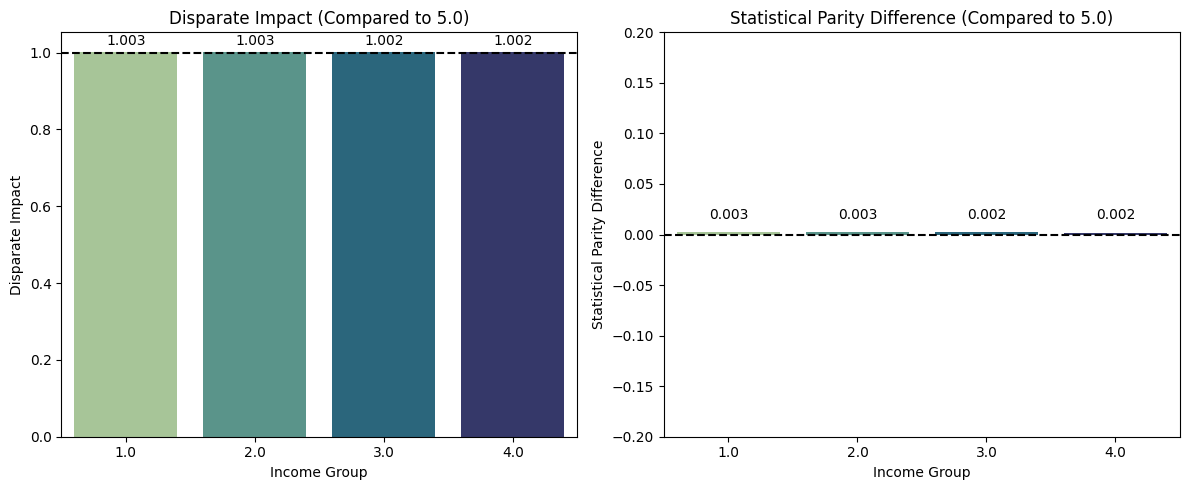

In [297]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_mlp_fair_fam_inc_race_tier')
plot_fairness_metrics(results, 'Income Group', 5.0)

In [298]:
print(confusion_matrix(df['pass_bar'], df['pass_bar_mlp_fair_fam_inc_race_tier']))

[[   12  1127]
 [    5 20928]]
